# **GROUP PROJECT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import geopandas as gpd
import random
from deap import base, creator, tools
import pyproj
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ortools as ort
import datetime as dt
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

C:\Users\Noah\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# **CLEAN UP, CLEAN UP, EVERYBODY EVERYWHERE**

In [15]:
# truck variables
truckRange = 10
truckCapacity = 500

In [16]:
def buildCityDF(nCities,gridX=100,gridY=100):
    xs = np.random.randint(0,gridX,nCities)
    ys = np.random.randint(0,gridY,nCities)
    pts = [Point(xs[i],ys[i]) for i in range(0,nCities)]
    demands = np.random.randint(0,101,nCities)
    cities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts})
    return cities

In [17]:
cities = buildCityDF(30)

In [18]:
def solveOriginal(cities,M = 100):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()

    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates}
    yj = {j: model.IntVar(0,1, 'y[%i]' % (j)) for j in range_facilityCandidates}
    
    obj = [(cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + 2*cij[0,j]*yj[j] for i in range_customers for j in range_facilityCandidates]
    
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
        
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
            
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= yj[j])
            
    for j in range_facilityCandidates:
        #model.Add(yj[j] <= M)
        model.Add(model.Sum([yj[j] for j in range_facilityCandidates]) <= M)
        

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    resultGDF["Status"] = [yj[j].solution_value() for j in range_facilityCandidates]
    
    return model,yj,xij,resultGDF,status

In [19]:
m,yj,xij,resultGDF,status = solveOriginal(cities,M=10)

Optimal Solution Found


Text(721.4, 0.5, 'City')

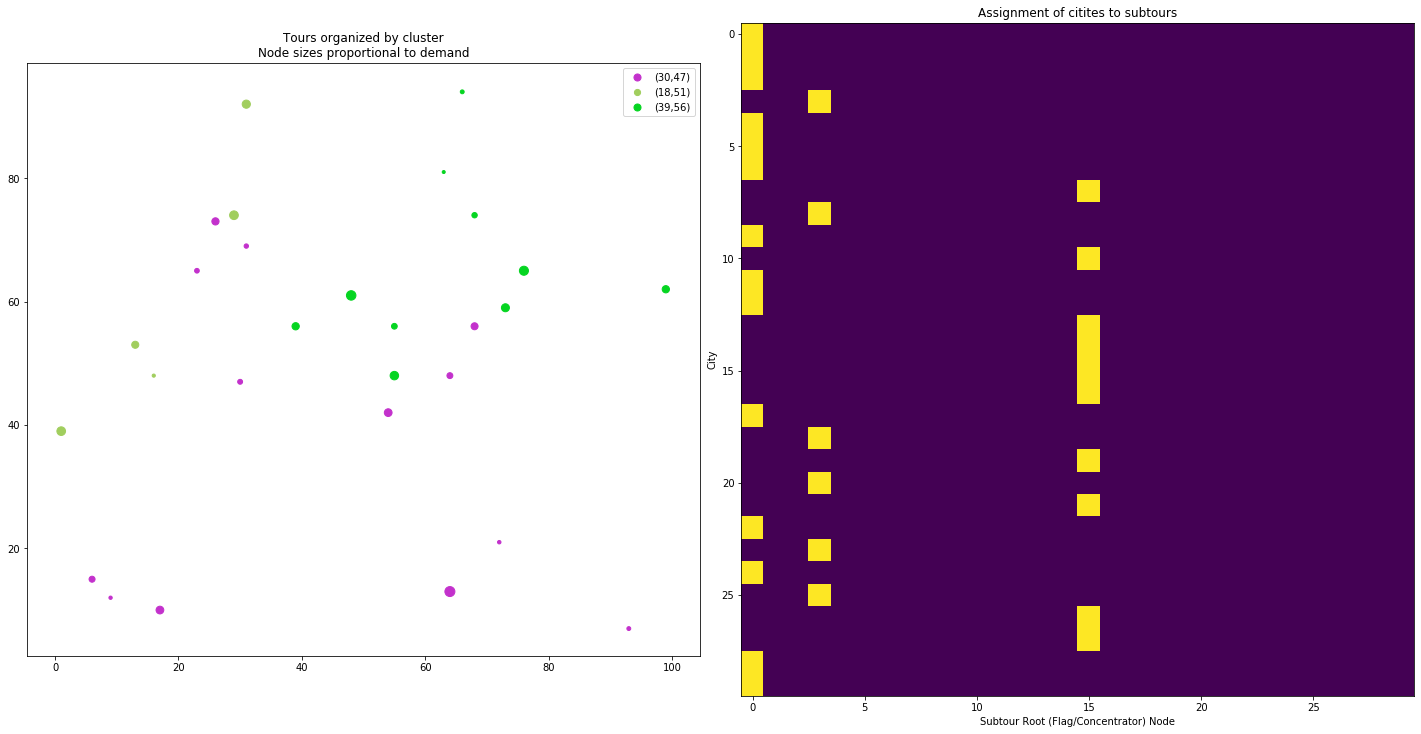

In [20]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y})")
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

In [2]:
def buildMinimumSpanningTree(df):
    """
    Utilizes Kruskal's algorithm
    """
    # 0. create dataframe of edges with weight, source, and destination
    if type(df) == gpd.geodataframe.GeoDataFrame:
        df_links = buildEdgeDf_Geo(df).sort_values("weight")
    else:
        df_links = buildEdgeDf(df).sort_values("weight")
    
    # 1. load all nodes into a graph
    graph = nx.Graph()
    graph.add_nodes_from(df.index)
    # 2. Implement Kruskal's algorithm by adding each edge in order by weight so long as it does not create a cycle
    for i,row in df_links.iterrows():
        verticesReached = []
        source = row["Source"]
        destination = row["Destination"]
        weight = row["weight"]
        graph.add_edge(source,destination)
        cyclesInGraph = nx.cycle_basis(graph)
        if len(cyclesInGraph) > 0: # check for cycle and remove edge if one is created
            graph.remove_edge(source,destination)
        if len(graph.edges) == len(graph.nodes) - 1:
            break
    # check results
    fullgraph = nx.from_pandas_edgelist(df_links,source="Source",target="Destination",edge_attr="weight")
    mst = nx.minimum_spanning_tree(fullgraph)
    isSameGraph = nx.is_isomorphic(graph,mst)
    print(f"The MST algorithm matches that of NetworkX: {isSameGraph}")
    return df_links,graph

In [3]:
df_150 = pd.read_excel("data150cities.xls")
df_150 = gpd.GeoDataFrame(df_150,geometry=gpd.points_from_xy(df_150.longitude, df_150.latitude))
df_150.index = df_150["City Index"]

In [4]:
df_150.crs = {'init' :'epsg:4326'}

# **PROPOSED SOLUTION APPROACH**

## 1. Data Inputs

In [26]:
cities

,x,y,demand,geometry
0,93,93,1,POINT (93 93)
1,77,7,23,POINT (77 7)
2,38,63,71,POINT (38 63)
3,77,47,40,POINT (77 47)
4,20,15,44,POINT (20 15)
5,79,15,90,POINT (79 15)
6,48,96,1,POINT (48 96)
7,50,1,49,POINT (50 1)
8,62,90,65,POINT (62 90)
9,95,89,16,POINT (95 89)


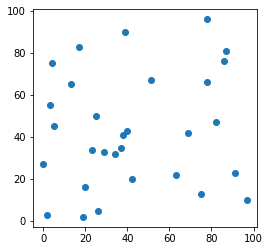

In [9]:
cities.plot()

## Step 1. Generate list of TSPs using a segmentation algorithm

In [11]:
def buildDistanceMatrix_Euclidean(cities):
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    return distances

In [12]:
distances = np.zeros((len(cities),len(cities)))
for i,row in cities.iterrows():
    for j,row2 in cities.iterrows():
        distances[j,i] = row.geometry.distance(row2.geometry)

In [13]:
solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)

In [14]:
cij = distances

In [15]:
n_customers = cij.shape[0]
range_customers = range(n_customers)

In [16]:
n_facilityCandidates = cij.shape[1]
range_facilityCandidates = range(n_facilityCandidates)

In [17]:
demands = np.array(cities["demand"])
demands_sum = demands.sum()

In [18]:
M = 10

In [19]:
def solveOriginal(alpha=75):
    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates}
    yj = {j: model.IntVar(0,1, 'y[%i]' % (j)) for j in range_facilityCandidates}
    obj = [(cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] for i in range_facilityCandidates for j in range_facilityCandidates] + [2*cij[0,j]*yj[j] for j in range_facilityCandidates]
    
    obj = [(cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + 2*cij[0,j]*yj[j] for i in range_customers for j in range_facilityCandidates]
    
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
        
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
            
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= yj[j])
            
    for j in range_facilityCandidates:
        #model.Add(yj[j] <= M)
        model.Add(model.Sum([yj[j] for j in range_facilityCandidates]) <= M)
        

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    resultGDF["Status"] = [yj[j].solution_value() for j in range_facilityCandidates]
    
    return model,yj,xij,resultGDF,status

In [20]:
m,yj,xij,resultGDF,status = solveOriginal()

Optimal Solution Found


In [21]:
status == pywraplp.Solver.OPTIMAL

True

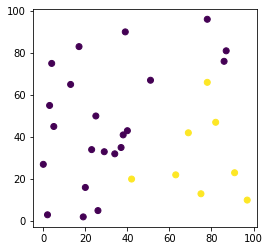

In [22]:
resultGDF.plot("Status")

In [23]:
resultGDF

,x,y,demand,geometry,Status
0,91,23,65,POINT (91 23),1.0
1,25,50,56,POINT (25 50),0.0
2,37,35,56,POINT (37 35),0.0
3,5,45,21,POINT (5 45),0.0
4,40,43,40,POINT (40 43),0.0
5,78,96,47,POINT (78 96),0.0
6,75,13,5,POINT (75 13),1.0
7,63,22,12,POINT (63 22),1.0
8,13,65,71,POINT (13 65),0.0
9,23,34,0,POINT (23 34),0.0


Text(0, 0.5, 'City')

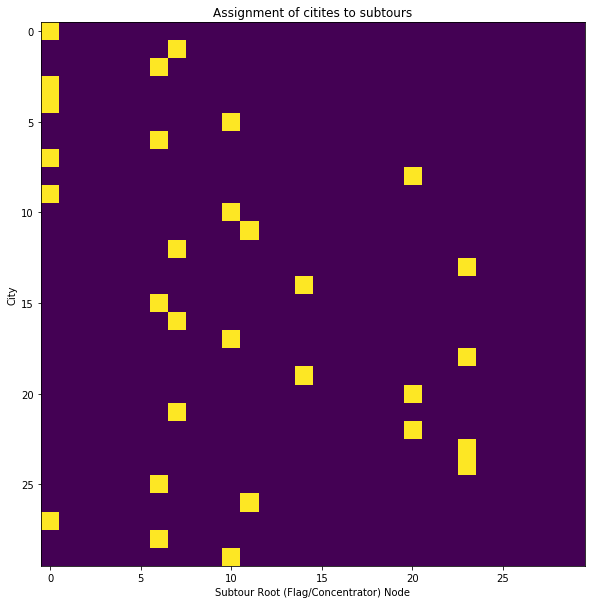

In [48]:
# Plot assignments
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()

fig,ax = plt.subplots(figsize=(10,10))
plt.imshow(assignments)
ax.set_title("Assignment of citites to subtours")
ax.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax.set_ylabel("City")

In [26]:
cluster = []
for cityNodeID in range_customers:
    for rootNodeID in range_facilityCandidates:
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)

In [27]:
cluster

[0,
 7,
 6,
 0,
 0,
 10,
 6,
 0,
 20,
 0,
 10,
 11,
 7,
 23,
 14,
 6,
 7,
 10,
 23,
 14,
 20,
 7,
 20,
 23,
 23,
 6,
 11,
 0,
 6,
 10]

In [28]:
resultGDF["assignment"] = cluster

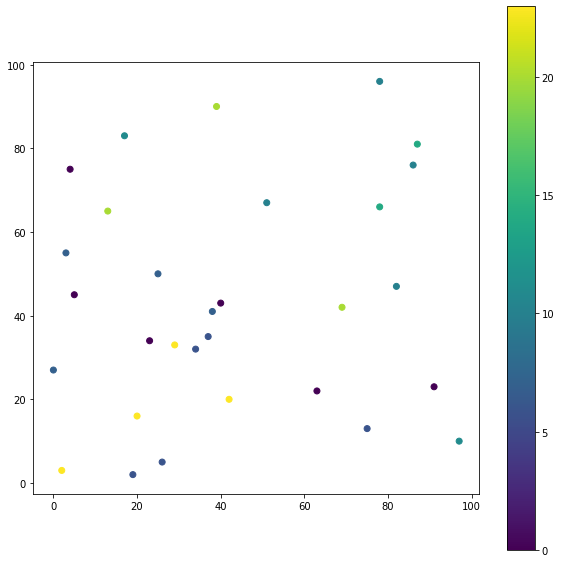

In [29]:
fig,ax = plt.subplots(figsize=(10,10))
resultGDF.plot("assignment",legend=True,ax=ax)
# resultGDF[resultGDF["Status"]==1].plot(marker='*',markersize=200,color='green',ax=ax)


In [30]:
uniqueClusters = list(set(cluster))

In [18]:
uniqueClusters

[0, 4, 10, 12, 13, 14, 16, 20, 22]

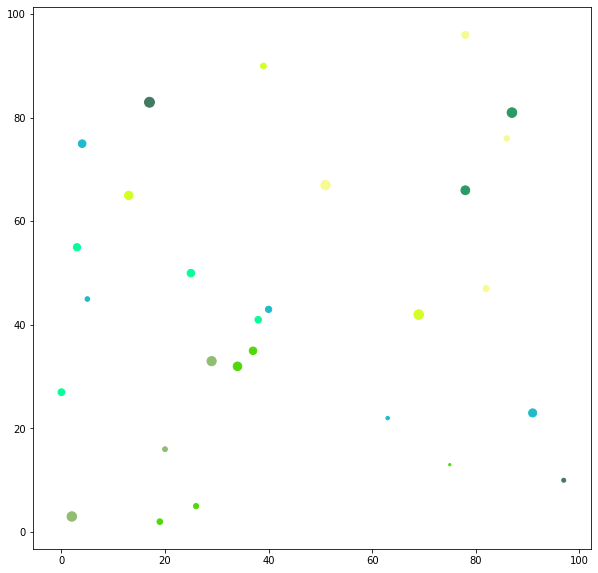

In [46]:
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
fig,ax = plt.subplots(figsize=(10,10))
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax,color=colors[i],markersize=dfSubset["demand"])

In [211]:
resultGDF

,x,y,demand,geometry,Status,assignment
0,4,10,60,POINT (4 10),1.0,0
1,38,93,83,POINT (38 93),0.0,17
2,9,47,7,POINT (9 47),0.0,26
3,15,87,67,POINT (15 87),0.0,26
4,45,28,34,POINT (45 28),0.0,10
5,99,70,8,POINT (99 70),0.0,0
6,18,56,6,POINT (18 56),0.0,26
7,89,35,100,POINT (89 35),0.0,10
8,41,63,8,POINT (41 63),0.0,0
9,56,67,18,POINT (56 67),0.0,23


By Tomorrow
- TSP code  with GA
- Test segementation code for size, loop through and see how long it takes to run

# **CHECK HOW LARGE WE CAN DO**

In [220]:
nCities = range(10,110,10)
gridX = 100
gridY = 100

In [ ]:
times = []
for nCity in nCities:
    startTime = dt.datetime.now()
    cities = buildCityDF(nCity,gridX=100,gridY=100)
    m,yj,xij,resultGDF,status = solveOriginal(cities)
    endTime = dt.datetime.now()
    totalTime = (endTime-startTime).total_seconds()
    times.append(totalTime)
    print(f"Completed {nCity} cities in {totalTime} seconds.  Optimal solution: {status == pywraplp.Solver.OPTIMAL}")

Optimal Solution Found
Completed 10 cities in 0.140653 seconds.  Optimal solution: True
Optimal Solution Found
Completed 20 cities in 3.084428 seconds.  Optimal solution: True
Optimal Solution Found
Completed 30 cities in 131.310688 seconds.  Optimal solution: True
